# ECO's Python M&V model

## Load Libraries


In [2]:
import pandas as pd
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import style
import numpy as np
from datetime import timedelta
from sklearn import svm, cross_validation, linear_model, preprocessing, ensemble
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib.pyplot import cm 
from pandas.tseries.offsets import MonthEnd
from scipy import stats

%matplotlib inline
style.use('ggplot')

## class DataGatherer

In [3]:
def load_data(f):
    dwnld_data = pd.read_csv(f, index_col=0)
    dwnld_data.index = pd.to_datetime(dwnld_data.index)
    #print dwnld_data.columns
    return dwnld_data

def get_data(f):
# this in the future will handle data from PI directly instead of data from .csv
    return load_data(f)

## class PreProcessor

In [4]:
#### Add  Useful Variables and Remove Unused Variables

def add_variables(data): # feature extraction function
# select columns needed
    colmn=[u'chw.bph', u'elec.bph', u'steam.bph', u'oat']#,u'steam.gallons']
    data=data.loc[:,colmn]
# rename columns
    data.columns=['chw','elec','steam','oat']#, "condensate"]
#add time-dependent variables
    data["YEAR"]=data.index.year
    data["MONTH"]=data.index.month
    data["TOD"]=data.index.hour
    data["DOW"]=data.index.weekday
    data["WEEK"]=data.index.week
    data["DOY"]=data.index.dayofyear

# force numeric type for all variables
    for col in data.columns:
        data[col]=pd.to_numeric(data[col], errors='coerce')
        
# add heating and cooling degree hours
    hdh_point=65
    cdh_point=65
    data['hdh']=data['oat']
    data.loc[data.loc[:,'hdh']>hdh_point,'hdh']=0 
    data.loc[data.loc[:,'hdh']<=hdh_point,'hdh']=hdh_point-data.loc[data.loc[:,'hdh']<=hdh_point,'hdh']
    data.loc[:,'cdh']=data['oat']
    data.loc[data.loc[:,'cdh']<cdh_point,'cdh']=0
    data.loc[data.loc[:,'cdh']>=cdh_point,'cdh']=data.loc[data.loc[:,'cdh']>=cdh_point,'cdh']-cdh_point
    return data

def clean_data(data):
# remove outliers: force values withinn band: < mean + 5sd ro remove outliers
    n=4
    cond_chw_min=0
    cond_chw_max=data.chw.mean()+(data.chw.std()*n)
    cond_elec_min=0
    cond_elec_max=data.elec.mean()+(data.elec.std()*n)
    cond_steam_min=0
    cond_steam_max=data.steam.mean()+(data.steam.std()*n)
    cond_oat_min=data.oat.mean()-(data.oat.std()*n)
    cond_oat_max=data.oat.mean()+(data.oat.std()*n)
# fill missing variables or cut outliers with mean data
    data.loc[((data.chw) < cond_chw_min) | ((data.chw)> cond_chw_max ) , "chw"] =data.loc[:,'chw'].mean()
    data.loc[((data.elec)< cond_elec_min ) |((data.elec)> cond_elec_max ),"elec"]=data.loc[:,'elec'].mean()
    data.loc[((data.steam)< cond_steam_min ) | ((data.steam)> cond_steam_max ), "steam"]=data.loc[:,'steam'].mean()
    data.loc[((data.oat)< cond_oat_min ) | ((data.oat)> cond_oat_max ) ]=data.oat.mean()
    data=data.dropna()

    data=special_case(data)
    return data

# bad pracetice do not do that
def special_case (data):
    for i in range (3):
        col="elec"
        data.loc[data[col]==data[col].max(),col]=data.loc[:,col].mean()
        col="chw"
        data.loc[data[col]==data[col].max(),col]=data.loc[:,col].mean()    
    return data

def remove_negative(dataNoBound):
    dataNoBound[dataNoBound < 0]=0
    return dataNoBound

## class ModelSelector

In [5]:
def train_model (model_data, tar, var, algorithm, mod_type, train_start, train_end, val_start, val_end):
    ## Model features 

# 1) Simple model with flat internal load
    if mod_type==1:
        model_col=var.remove['hdh','cdh']
# 2) Model with Internal Gain profile by time, week and month
    elif mod_type==2:
        model_col=var
        add_var=pd.get_dummies(model_data["TOD"],prefix="TOD_") # turn time of day into dummy variables
        model_data=model_data.join(add_var) # add all the columns to the model data
        model_col=var+add_var.columns.tolist() # full list of variable for regression

        add_var=pd.get_dummies(model_data["DOW"],prefix="DOW_") # turn day of week into dummy variables
        model_data=model_data.join(add_var) # add all the columns to the model data
        model_col=model_col+add_var.columns.tolist() # full list of variable for regression

        add_var=pd.get_dummies(model_data["MONTH"],prefix="MONTH_") # turn month into dummy variables
        model_data=model_data.join(add_var) # add all the columns to the model data
        model_col=model_col+add_var.columns.tolist() # full list of variable for regression

# Select Training Set
    data_train=model_data.loc[train_start:train_end, model_col]#.dropna() # slice training period
    #if val_start & val_end
    data_train=data_train.drop(data_train[val_start:val_end].index) #remove validation intervals
    target_train=model_data.loc[train_start:train_end,tar]#.dropna()
    target_train=target_train.drop(target_train[val_start:val_end].index) #remove validation intervals


# Train a simple linear model
    if algorithm==1:
        clf = linear_model.LinearRegression()    
    elif algorithm==2:
        clf = ensemble.RandomForestRegressor()
        
    model=clf.fit(data_train,target_train)

# Save the predicted target
    target_modeled_train=model.predict(data_train)
# Set negative values (energy) to zero
    target_modeled_train=remove_negative(target_modeled_train)

# save actual target and predicted target side by side
    compare=pd.DataFrame(target_train)
    compare.columns=["target_actual"]
    compare["target_predicted"]=target_modeled_train    
# Save the score
    score=model.score(data_train,target_train) #replace this with functions

# Print model coefficients (to see what are the weights)
#    print "Model variables const + %s" %model_col 
#    print "Model coeff %s + %s"   % (model.intercept_, model.coef_)

    return {"model":model,"data_train":data_train,"target_train":target_train,"model_data":model_data,
            "model_col":model_col,"score":score, "target_modeled_train":target_modeled_train, "compare":compare}

def predict_model (model_data, tar, var, model, val_start, val_end):
    # Select Validation set 
    model_col=var
# select columns and lines
    data_val=model_data.loc[val_start:val_end,model_col]#.dropna()
    target_val=model_data.loc[val_start:val_end,tar]#.dropna()

# Save the predicted target
    target_modeled_val=model.predict(data_val)
# Set negative values (energy) to zero
    target_modeled_val=remove_negative(target_modeled_val)

# save actual target and predicted target side by side
    compare=pd.DataFrame(target_val)
    compare.columns=["target_actual"]
    compare["target_predicted"]=target_modeled_val    
# Save the score
    score=model.score(data_val,target_val)

    return {"score":score, "target_modeled_val":target_modeled_val, "compare":compare}

def calc_scores(compare,p):
    scores={}
    
    n=compare.count()[1]
    R2=r2_score(compare["target_actual"], compare["target_predicted"]) # this can be negative
    RMSE=(mean_squared_error(compare["target_actual"], compare["target_predicted"])*n/(n-p))**(0.5)
    CV_RMSE=RMSE*100/compare["target_actual"].mean()
    NMBE =compare["target_actual"].sub(compare["target_predicted"]).sum()/(compare["target_predicted"].mean())/(n-p)*100
    scores["Adj_R2"]= 1-(1-R2)*(n-1)/(n-p-1)
    scores["RMSE"]=RMSE
    scores["CV_RMSE"]=CV_RMSE
    scores["NMBE"]=NMBE
    return scores

## class SavingCalculator

In [6]:
def calc_savings(model_data, tar, var, model, val_start, val_end):
    return predict_model(model_data, tar, var, model, val_start, val_end)

#def savings_table_byMo (data_, tar, cost  ):
#    data_[tar]=(data_["target_predicted"]-data_["target_actual"])*cost[tar]
#    #data_[tar+"sav_perc"]=data_[tar]/(data_["target_predicted"]+0.01)*100 for savings %
#    time_res="M"
#    data_table=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).sum()[tar])
#    return data_table.to_dict()

def savings_table_byMo (data_, tar, cost  ):
# for cost savings
    time_res="M"
    data_cost_sav={}
    data_perc_sav={}
    data_=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).sum())
# cost savings 
    data_[tar]=(data_["target_predicted"]-data_["target_actual"])*cost[tar]
# % savings
    data_[tar+"sav_perc"]=(data_["target_predicted"]-data_["target_actual"])/(data_["target_predicted"]+0.01)*100
    #data_cost_sav=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).sum()).to_dict()
    #data_perc_sav=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).mean()[tar+"sav_perc"])#.to_dict()
    data_cost_sav[tar] = data_[tar].to_dict()
    data_perc_sav[tar] =data_[tar+"sav_perc"].to_dict()
    return {"data_cost_sav":data_cost_sav, "data_perc_sav":data_perc_sav}

#def calc_uncert(compare_train, confidence, score_tot, tar, absol):
#    alpha=(100-confidence)/100. #0.05 = 95% confidence ; t-statistic 2-tail
#    n=(len(compare_train))
#    t_stat=stats.t.ppf(1-alpha/2, n)
#    RMSE_val=score_tot[tar]["score_train"]["RMSE"]
#    smpl_siz=math.sqrt((1+1/(len(compare_train)*1.0)))
#    
#    if absol==True:
#        return t_stat*RMSE_val*smpl_siz #absolute error
#    else:
#        return t_stat*RMSE_val*smpl_siz/compare_sav["target_actual"].mean()*100

def calc_uncert(compare_train, compare_sav, confidence, score_tot, tar, absol):
    alpha=(100-confidence)/100. #alpha=0.05 for 95% confidence ; t-statistic 2-tail
    n=(len(compare_train)) # n samples in training
    m=(len(compare_val)) # m samples in validation
    
# adjust n due to autocorrelation of residuals in training (see ASHRAE guideline 14 - annex B2) 
    res=compare_train["target_predicted"]-compare_train["target_actual"]
    rho=res.autocorr()
    n_p= n*(1-rho)/(1+rho) # n' in annex B2
    
    smpl_siz=(n/n_p*(1+(2/n_p))*1/m)**0.5
    #smpl_siz=math.sqrt((n+2)/(n*m*1.0))
    sav_perc=(res/compare_train["target_predicted"]).sum()/100
    
    t_stat=stats.t.ppf(1-alpha/2, n)
    CV_RMSE_val=score_tot[tar]["score_train"]["CV_RMSE"]
    #smpl_siz=math.sqrt((n+2)/(n*m*1.0))
    
    print n, m, t_stat, CV_RMSE_val, smpl_siz
    if absol==True:
        return 1.26*t_stat*CV_RMSE_val*smpl_siz/sav_perc #+- % error
    else:
        return 1.26*t_stat*CV_RMSE_val*smpl_siz*(compare_sav["target_actual"].sum())    

## class Plotter

In [7]:
def plot_energy_profile_byMo (date_start, date_end, data, tar):
    # daily energy profile by Month (each line is an avergage month)
    data_graph=data[date_start: date_end]
    data_graph["YR-MO"]=data_graph.YEAR.astype(int).astype(str).str.cat(data_graph.MONTH.astype(int).astype(str), sep='-')    
    temp=data_graph.groupby(["TOD","YR-MO"]).mean()[tar].unstack()
    n=len(temp.columns)
    color=cm.rainbow(np.linspace(0,1,n))
    temp.plot(figsize=(15,5),label=tar, color=color, title=tar,ylim=[0,temp.max().max()*1.1])
    plt.show()

def plot_WD_WE (data, tar ):
    WD=data["DOW"]<5
    WE=data["DOW"]>=5
    time_res="d"
    WD_tmp=data[WD].groupby(pd.TimeGrouper(time_res)).mean().loc[:,tar]
    WD_tmp.plot(figsize=(15,5), style='o', title=tar,ylim=[0,WD_tmp.max()*1.1]) #WD
    WE_tmp=data[WE].groupby(pd.TimeGrouper(time_res)).mean().loc[:,tar]
    WE_tmp.plot(figsize=(15,5), style='o', title=tar, ylim=[0,WE_tmp.max()*1.1]) #WE
    plt.show()
        
    data_plot=pd.DataFrame()
    data_plot["WD"]=data[WD].groupby(pd.TimeGrouper(time_res)).mean().loc[:,tar]
    data_plot["WE"]=data[WE].groupby(pd.TimeGrouper(time_res)).mean().loc[:,tar]
    data_plot.plot( kind="box",figsize=(15,5), title=tar, ylim=[0,data_plot.max().max()*1.1])
    plt.show()
    
def plot_scatter (data, tar, x_var, perPre, perPost):
    dataPre=data["PrePost"]==perPre
    dataPost=data["PrePost"]==perPost
    ax=data[dataPre].plot(kind="scatter", x=x_var, y=tar,figsize=(15,5), title=tar)
    data[dataPost].plot(kind="scatter", x=x_var, y=tar,figsize=(15,5), color="r", ax=ax)
    plt.show()
    
def plot_compare (compare_data,plot_start,plot_end):
    compare_data.loc[plot_start:plot_end,:].plot(figsize=(15,5),title=tar)#.set_title("month = %d" %month)  
    plt.show() 

def plot_PrePost_byMo (data, tar):
    last_mo=data[data["PrePost"]==1].index.max().month
    temp=data.groupby(["MONTH","YEAR"])[tar].mean().unstack()
    temp[(temp.index<=last_mo)].plot(figsize=(15,5), kind="bar",title=tar)
    plt.show()
    
def plot_ModPost_byMo (compare_sav, tar):
    cols=["target_predicted", "target_actual"]
    compare_sav = compare_sav.ix[:, cols]
    compare_sav.groupby(compare_sav.index.month).mean().plot(figsize=(15,5), kind="bar",title=tar)
    plt.show()
    
def plot_PrePostSav_byMo(data, tar):
    last_mo=data[data["PrePost"]==1].index.max().month
    temp=data.groupby(["MONTH","YEAR"])[tar].mean().unstack()
    (temp[(temp.index<=last_mo)].diff(axis=1)*(-1)).plot(figsize=(15,5), kind="bar",title=tar)
    plt.show()

def plot_ModPostSav_byMo(compare_sav, tar):
    cols=["target_predicted", "target_actual"]
    compare_sav = compare_sav.ix[:, cols]
    (compare_sav.groupby(compare_sav.index.month).mean().diff(axis=1)*(-1)).plot(figsize=(15,5), kind="bar",title=tar)
    plt.show()
    

In [8]:
def plot_daily_profile (compare_data):
# add select and group by variables
    compare_data["MONTH"]=compare_data.index.month
    compare_data["TOD"]=compare_data.index.hour
    mi=compare_data["MONTH"].min()
    ma=compare_data["MONTH"].max()

    for month in range (mi,ma+1):
        cond=compare_data["MONTH"]==month
        col=['target_actual', 'target_predicted', 'TOD']
        compare_red=compare_data.loc[cond,col]
        compare_grouped=compare_red.groupby("TOD").mean()
        compare_grouped.plot(figsize=(18,5)).set_title("month = %d" %month)    
#    plt.close() 

def plot_savings(compare,time_res):
    compare_val.diff(periods=1, axis=1).iloc[:,1].groupby(
        pd.TimeGrouper(time_res)).mean().interpolate(method='time').plot(kind="bar", figsize=(10,5))

# Main Function

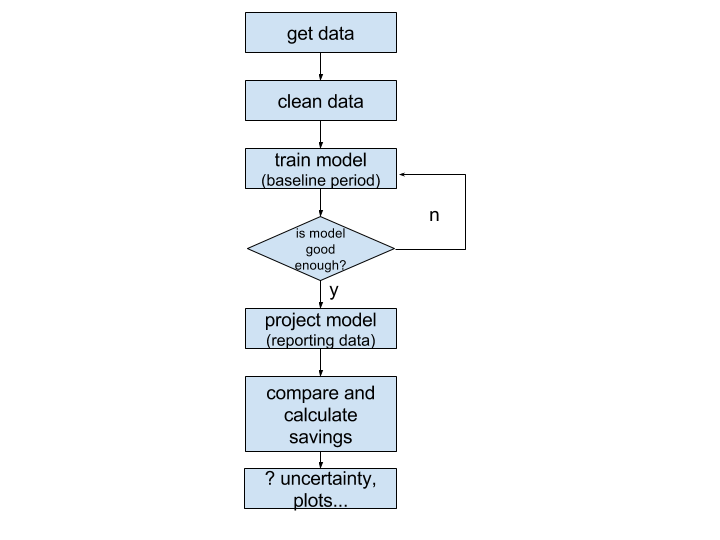

In [9]:
from IPython.display import Image
Image("MV_Procedure.png")
# diagram of the process

In [11]:
# going to be configuration file with all variables

cost_ele =0.0766/3412.14 #
cost_steam =0.10025/9126 # $/gal * gal/BTU ***note: use hourly data here
cost_chw =0.1/12000  #

cost={"elec":cost_ele,
     "steam":cost_steam,
     "chw":cost_chw}

data time range:  2012-08-01 01:00:00 - 2017-12-31 23:00:00 

Target Var is        chw
Training time range:   2016-04-01 00:00:00 - 2016-11-01 00:00:00
Validation time range: 2015-04-01 00:00:00 - 2015-04-07 00:00:00
score train = 
{'Adj_R2': 0.99370514143283417, 'CV_RMSE': 7.6380292134449759, 'NMBE': -0.08740413249739637, 'RMSE': 54647.134869755515}
score val = 
{'Adj_R2': 0.82055334569720095, 'CV_RMSE': 50.305664529196001, 'NMBE': 55.11835575320488, 'RMSE': 145426.69879916008}


5137 145 1.96042589242 7.63802921344 0.130304070413
2.41648004301


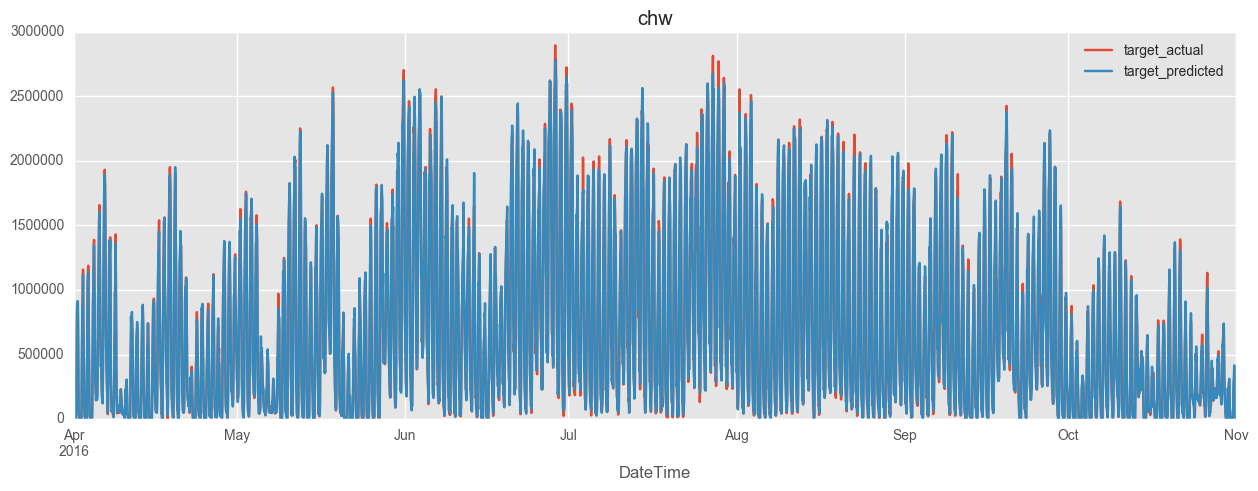

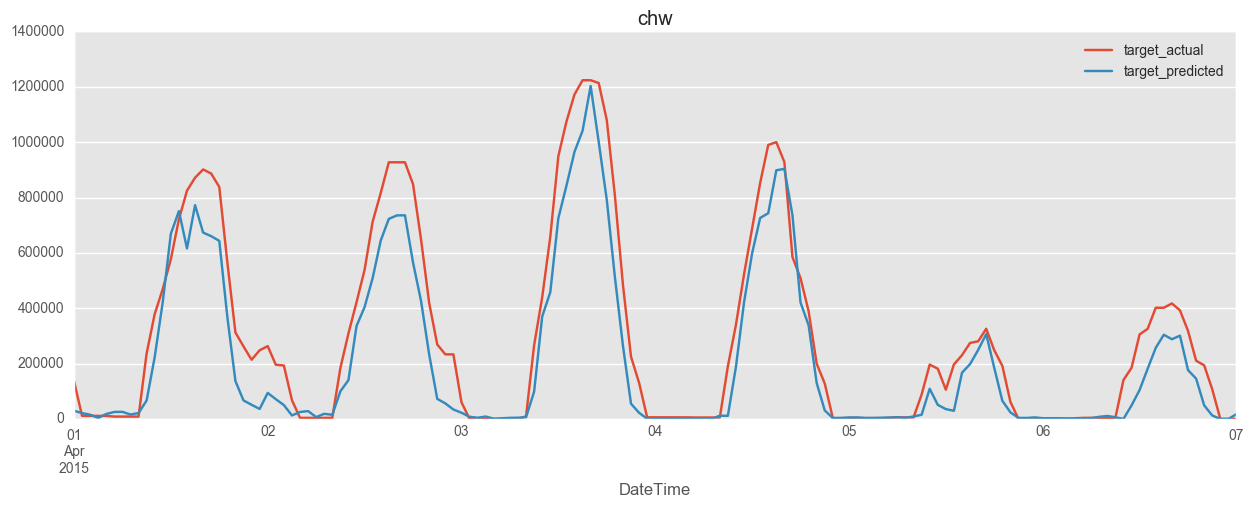

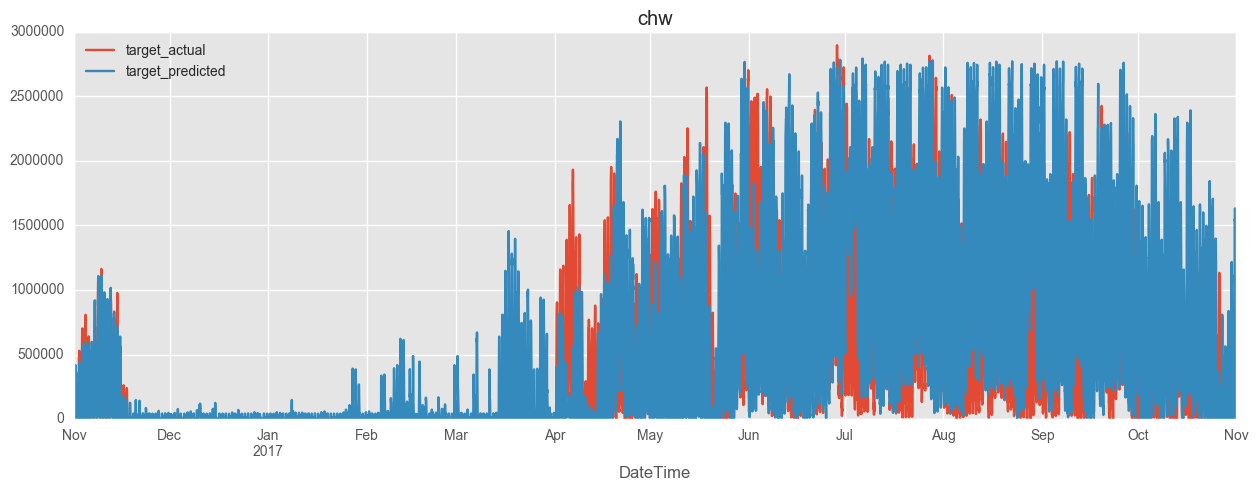

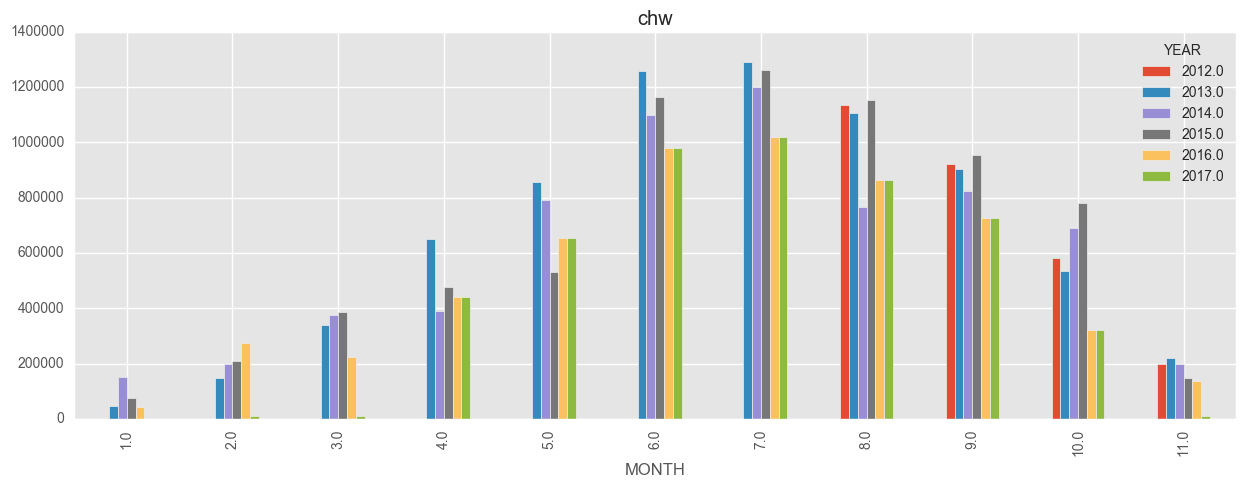

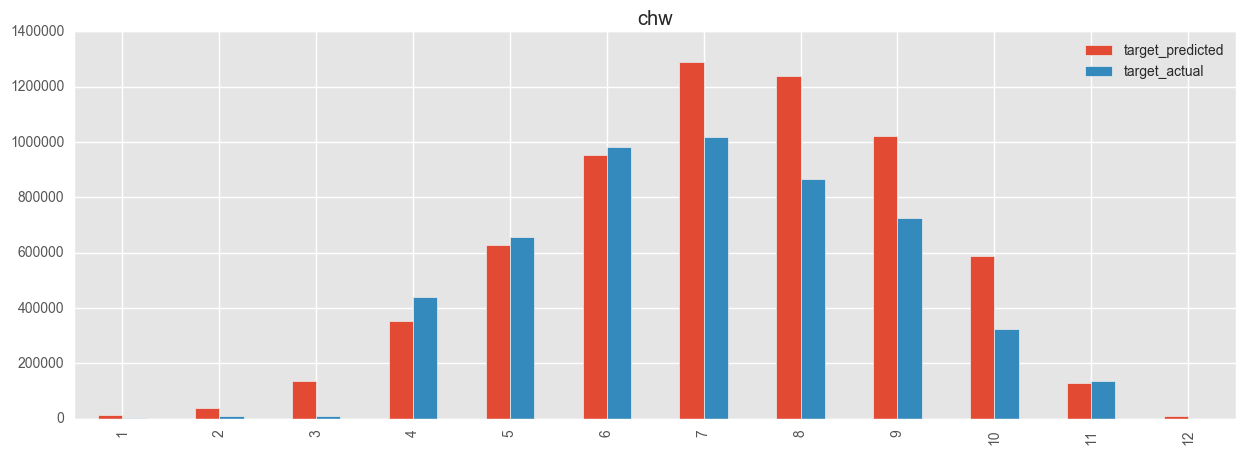

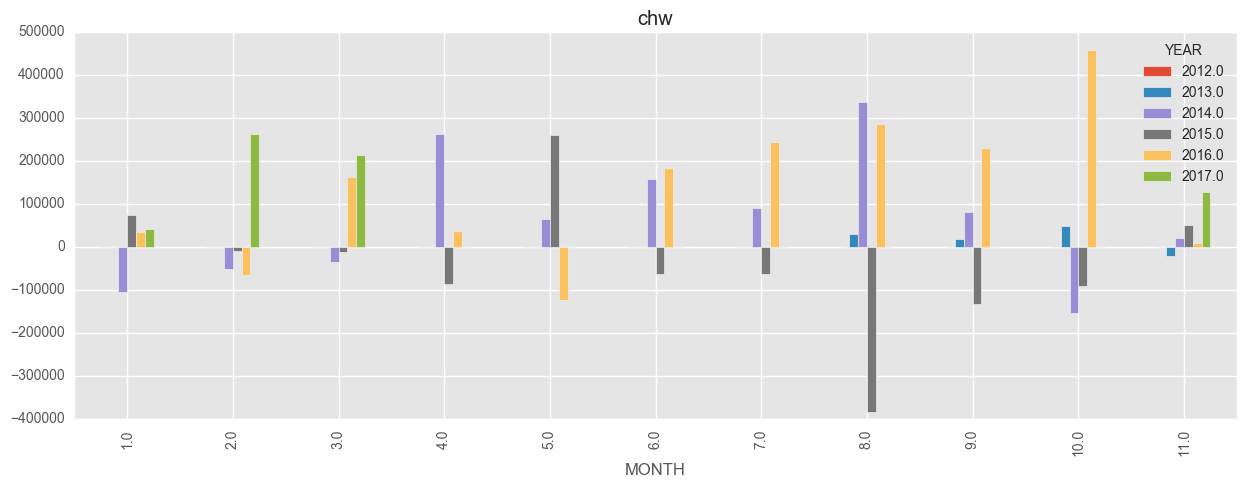

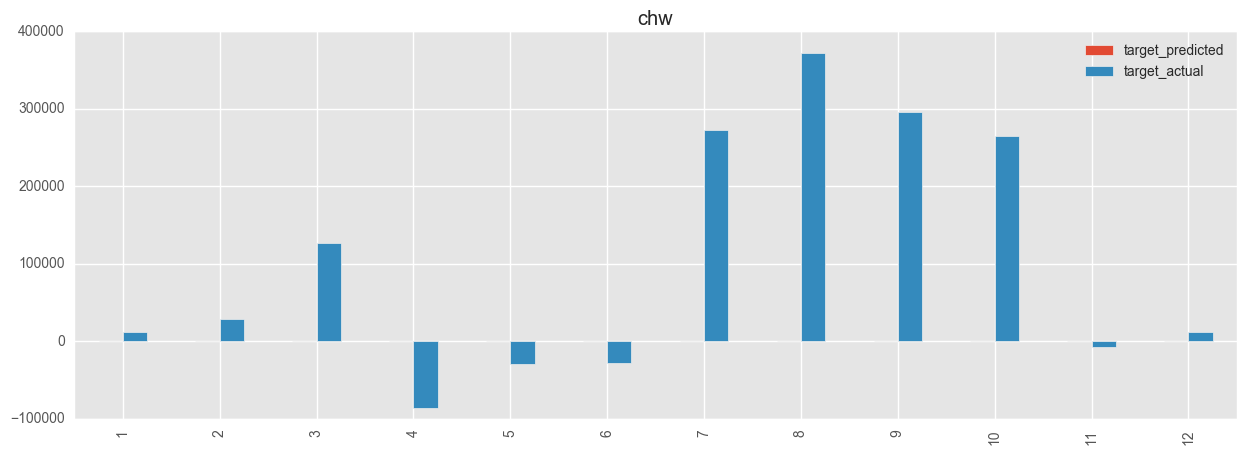

Target Var is        elec
Training time range:   2016-04-01 00:00:00 - 2016-11-01 00:00:00
Validation time range: 2015-04-01 00:00:00 - 2015-04-07 00:00:00
score train = 
{'Adj_R2': 0.9694013958327653, 'CV_RMSE': 3.0103350381754073, 'NMBE': -0.03678518012854187, 'RMSE': 12174.223888943796}
score val = 
{'Adj_R2': -0.33336174940340357, 'CV_RMSE': 15.53040339275443, 'NMBE': 17.265408057172564, 'RMSE': 74143.975104160345}


5137 145 1.96042589242 3.01033503818 0.164467460779
29.6354875025


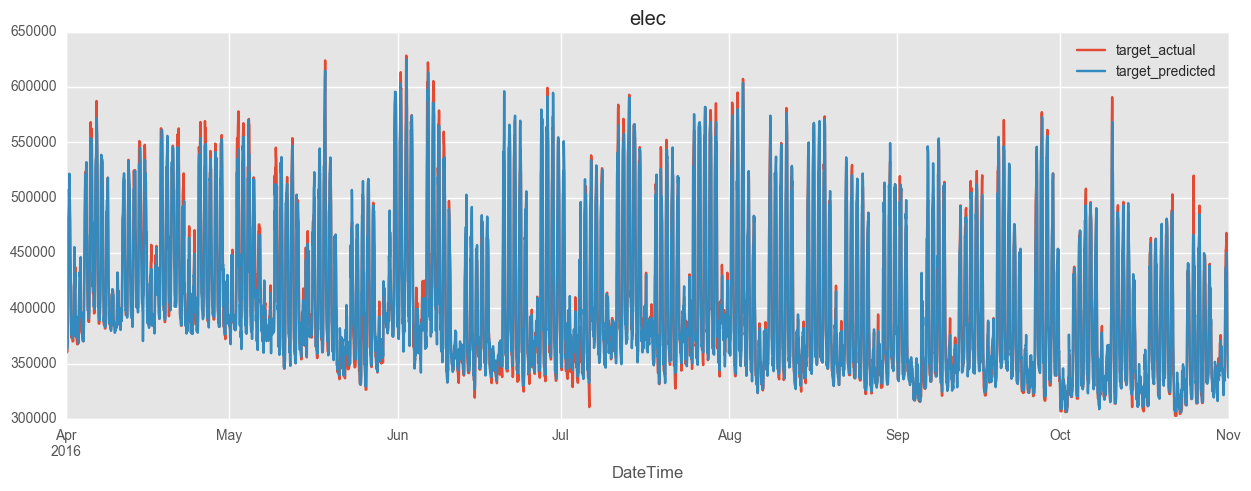

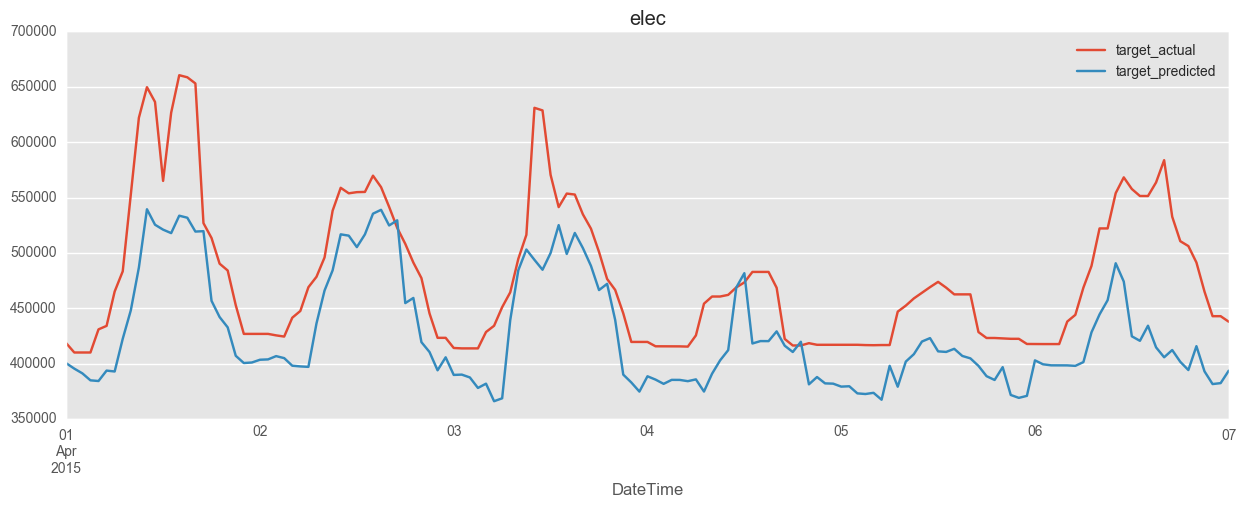

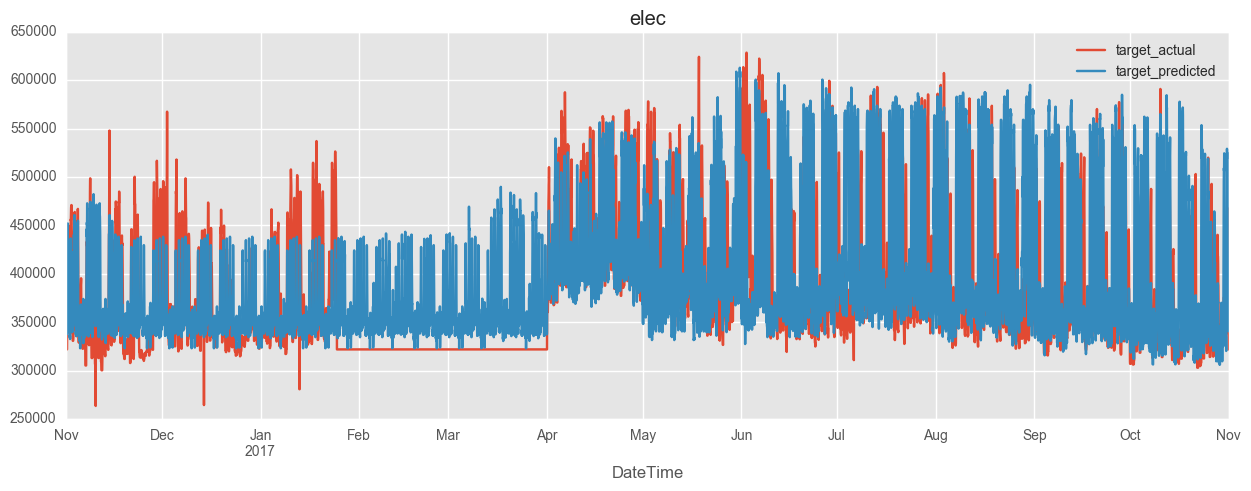

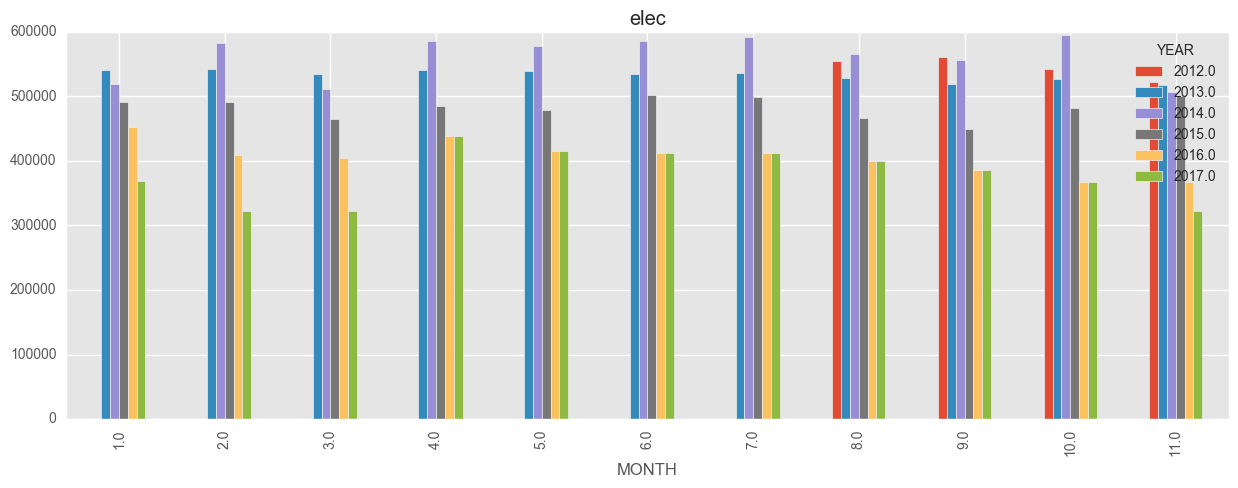

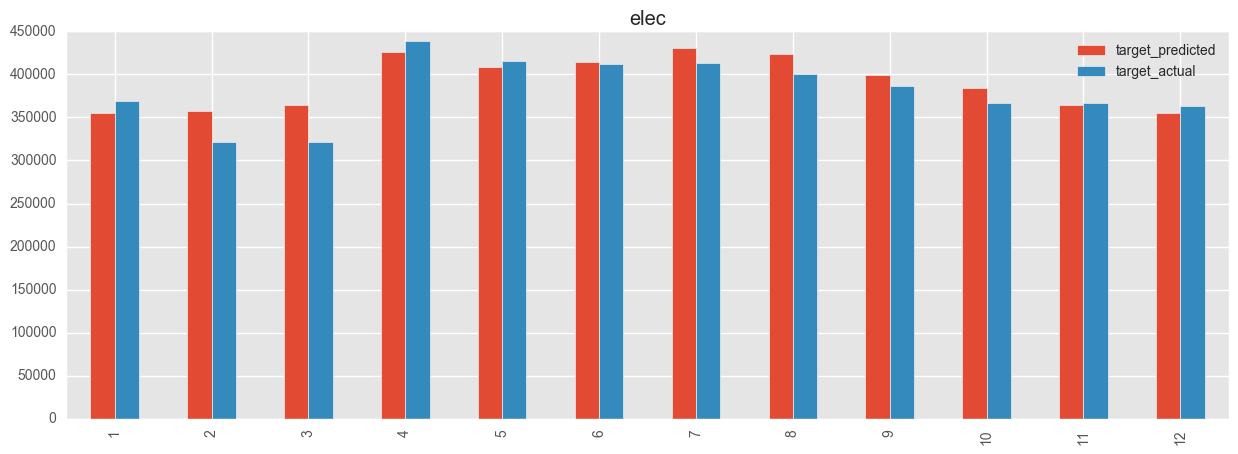

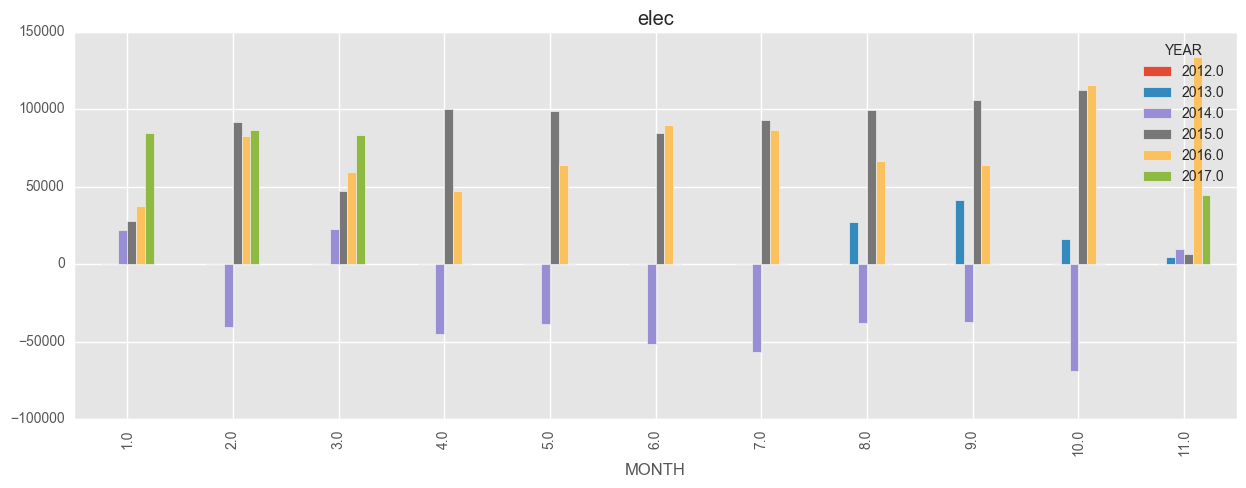

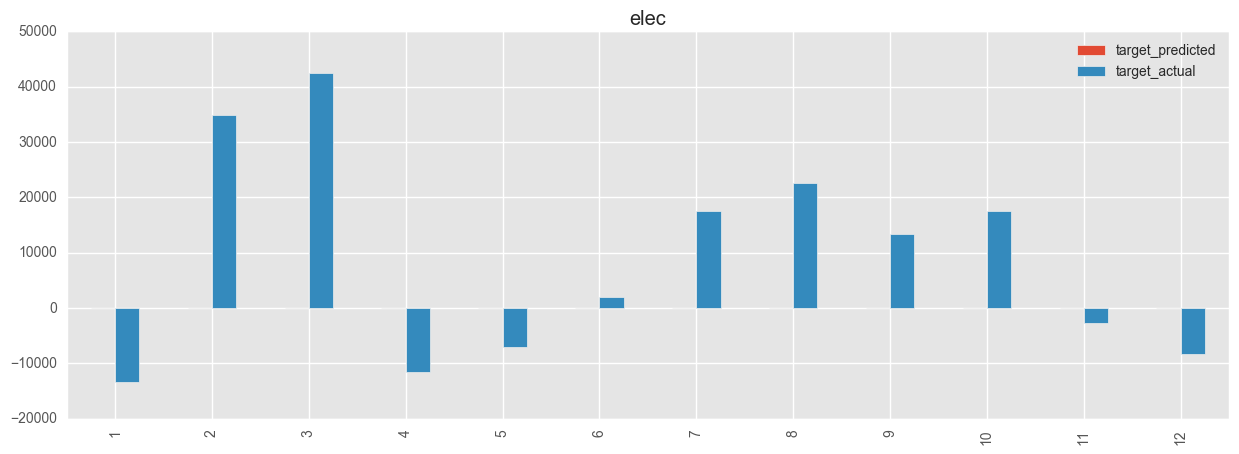

Target Var is        steam
Training time range:   2016-04-01 00:00:00 - 2016-11-01 00:00:00
Validation time range: 2015-04-01 00:00:00 - 2015-04-07 00:00:00
score train = 
{'Adj_R2': 0.94311875881132035, 'CV_RMSE': 5.6480465684003942, 'NMBE': 0.034872727925956234, 'RMSE': 19093.420980726736}
score val = 
{'Adj_R2': 0.43579488425391266, 'CV_RMSE': 31.212482807535611, 'NMBE': 23.85609078080509, 'RMSE': 185561.43916833104}


5137 145 1.96042589242 5.6480465684 0.123500780933
35.671766086


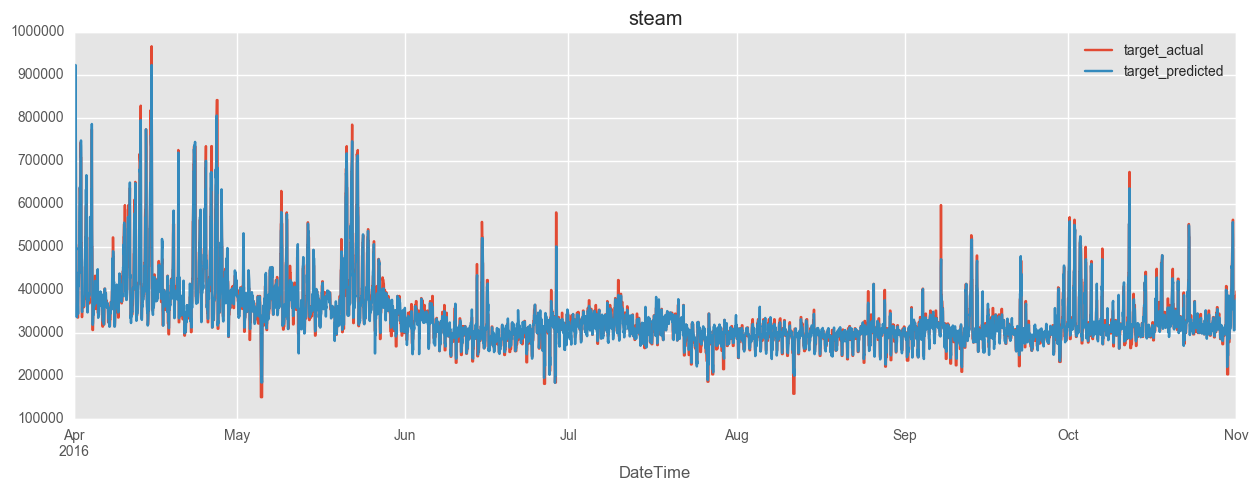

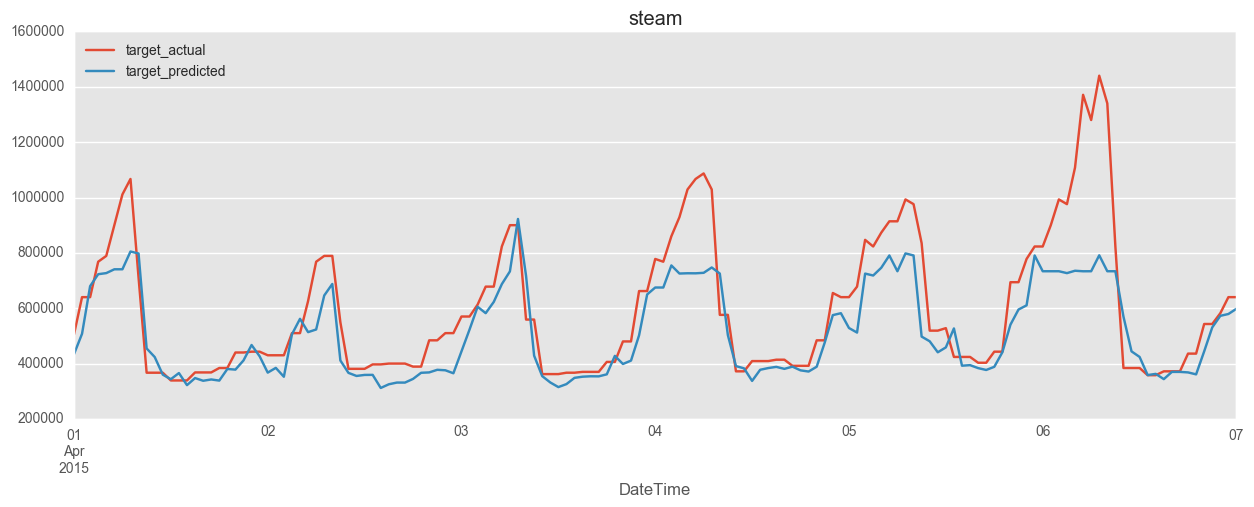

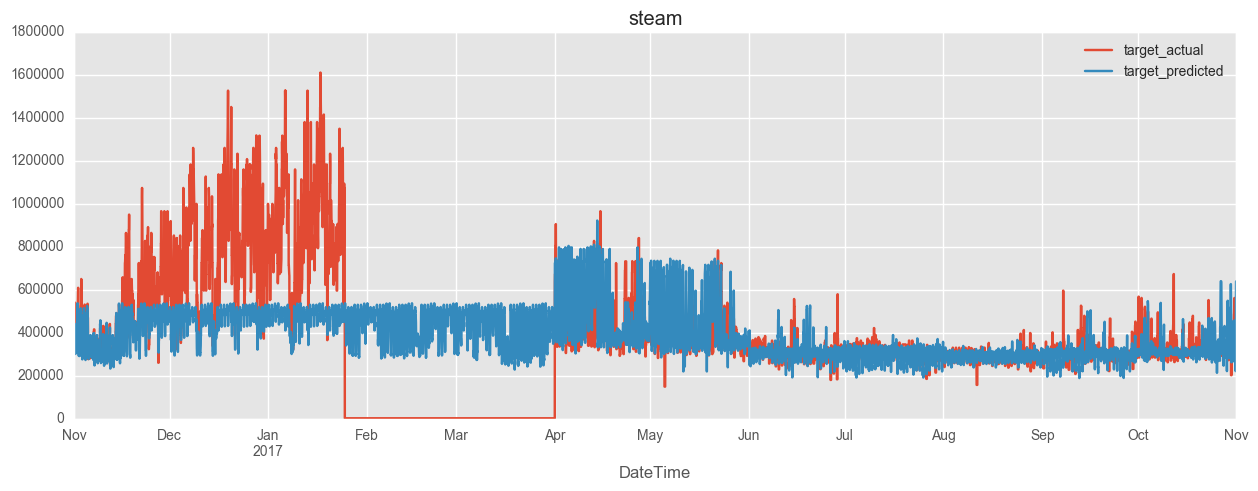

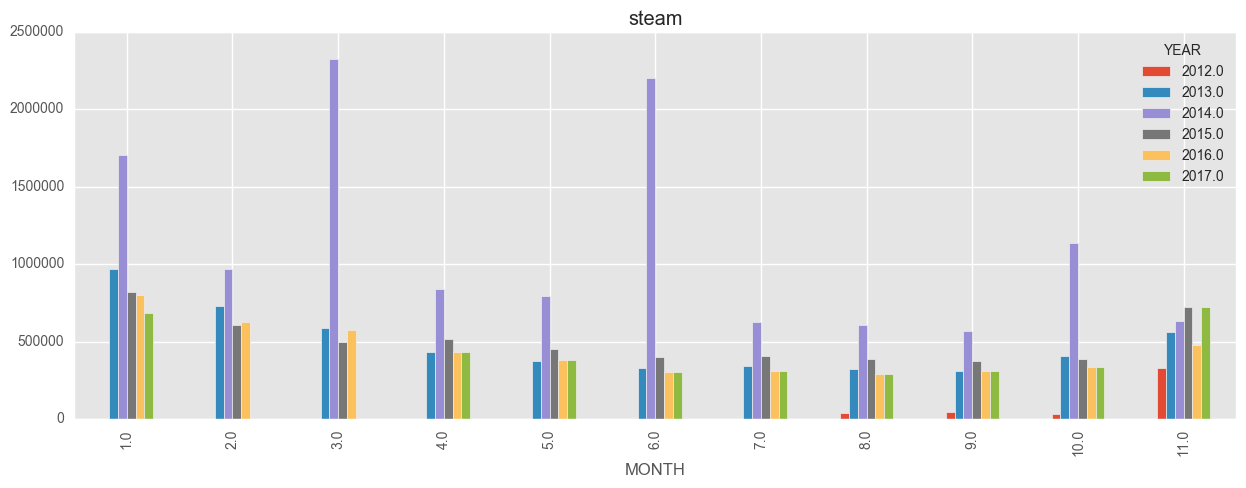

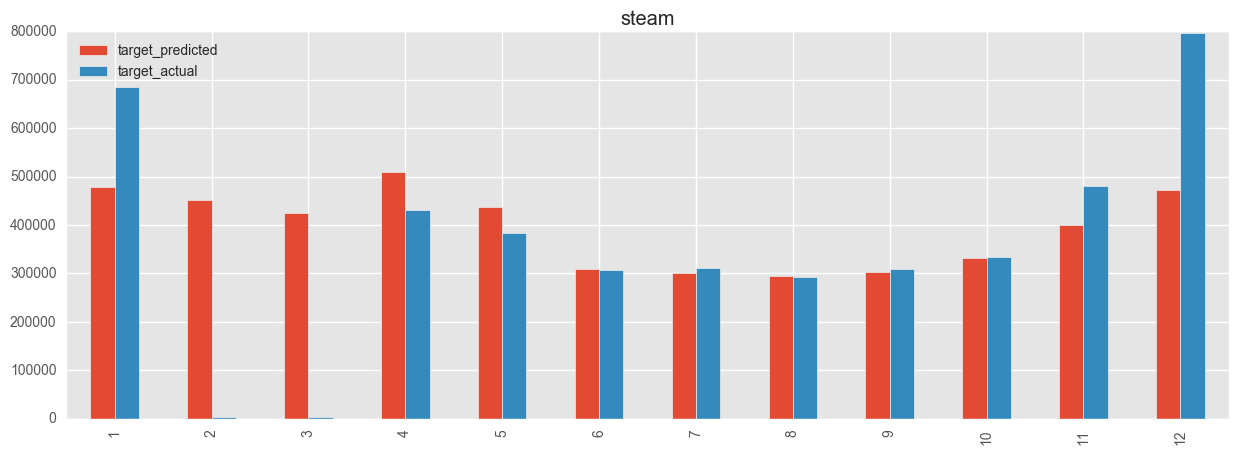

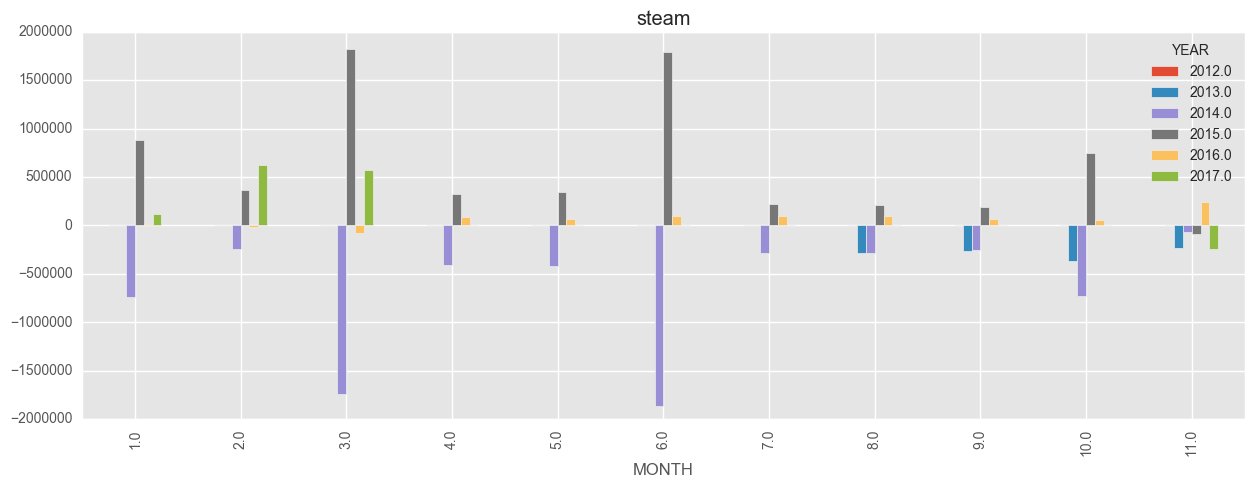

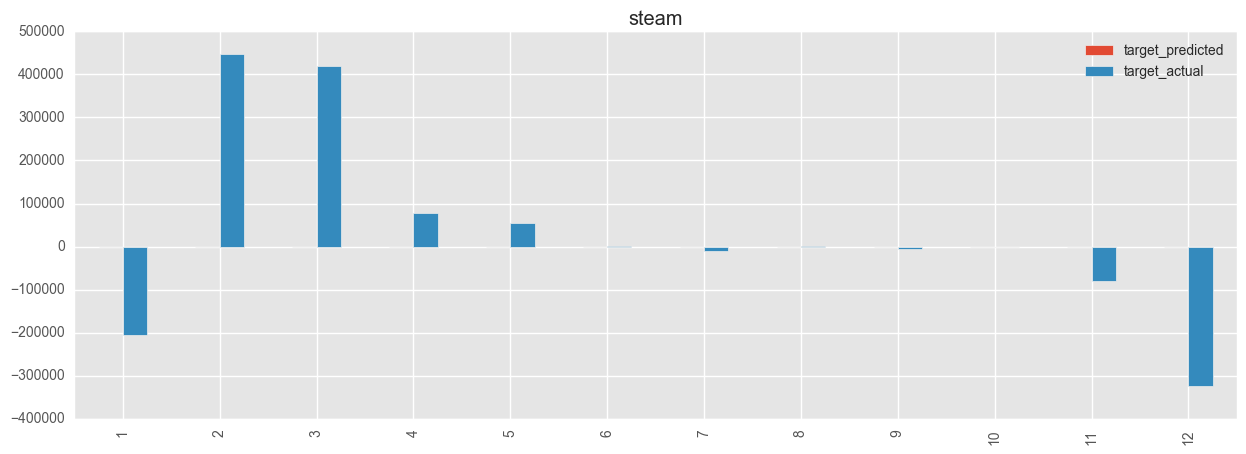

                     Adj_R2    CV_RMSE       NMBE           RMSE
major minor                                                     
chw   score_train  0.993705   7.638029  -0.087404   54647.134870
      score_val    0.820553  50.305665  55.118356  145426.698799
elec  score_train  0.969401   3.010335  -0.036785   12174.223889
      score_val   -0.333362  15.530403  17.265408   74143.975104
steam score_train  0.943119   5.648047   0.034873   19093.420981
      score_val    0.435795  31.212483  23.856091  185561.439168
       2016-11-30   2016-12-31   2017-01-31   2017-02-28   2017-03-31  \
chw    -42.909482    73.063511    77.063662   160.604778   783.400417   
elec   -43.334196  -137.134785  -224.268611   526.331431   710.627212   
steam -643.548701 -2644.407558 -1686.400846  3308.113052  3433.440236   

       2017-04-30  2017-05-31  2017-06-30   2017-07-31   2017-08-31  \
chw   -517.481190 -179.512423 -171.067143  1689.210718  2309.519288   
elec  -188.019975 -116.207669   32.235473   2

In [12]:
# Main
if __name__ == "__main__":
   
    # file source variables
    FOLDER='data'
    FILE= 'Ghausi_M&V Data.csv'
    #FILE= 'PES_M&V Data.csv'
    
# LOAD DATA
    dwnld_data=get_data(os.path.join(FOLDER,FILE))

# CLEAN DATA
    data=add_variables(dwnld_data)   
    data=clean_data(data)
    #print data

## TASKS
    explor=False #plots exploratory graphs
    search=True # iterates to get best model
    
# define pre-post    
    pre_start =pd.to_datetime('4,1,2016',  format='%m,%d,%Y', errors ='coerce', dayfirst=False)
    pre_end = pd.to_datetime('11,1,2016', format='%m,%d,%Y', errors ='coerce', dayfirst=False)
    post_start =pd.to_datetime('11,1,2016', format='%m,%d,%Y', errors ='coerce', dayfirst=False)
    post_end = pd.to_datetime('11,1,2017', format='%m,%d,%Y', errors ='coerce', dayfirst=False)
    data["PrePost"]=np.nan
    data.loc[pre_start:pre_end,"PrePost"]=0
    data.loc[post_start:post_end,"PrePost"]=1

# select energy type variables
    energy_type=["chw","elec", "steam"]
    #energy_type=["chw"]
# select other regressors
    var = ['hdh','cdh']
# select regression algorithm    
    algorithm =2
    mod_type =2

### PLOTS FOR EACH ENERGY TYPE
# PLOT GROUP 1: DATA EXPLORATORY GRAPHS
    if explor==True:
        for tar in energy_type:
# PLOT G1-1: profile of energy by hour of day, a line per month       
            #plot_energy_profile_byMo("2012", "2013", data, tar)
        
# PLOT G1-2: WD/WE profiles in time 
# note: add holidays !!!! 
            #plot_WD_WE (data, tar) 

# PLOT G1-3: scatter plot
            x_var="oat"
            perPre=0
            perPost=1
            plot_scatter (data, tar, x_var, perPre, perPost)
        
    print "data time range:  %s - %s \n" % (data.index.min(), data.index.max())

### FOR LOOP 1: cycle through energy types    
    score_tot={}
    saving_cost={}
    saving_perc={}
    uncert_tot={}
    
    
    for tar in energy_type: # as an alternative to define it explicitely use k-fold cross validation with sci-kit learn...

# Training Period - Use the full period, then the validation will be dropped later
        train_start =pre_start
        train_end = pre_end
# Validation Period; va
        val_start =pd.to_datetime('4,1,2015',  format='%m,%d,%Y', errors ='coerce', dayfirst=False)
        val_end = pd.to_datetime('4,7,2015',  format='%m,%d,%Y', errors ='coerce', dayfirst=False)

# period to calculate savings over
        pred_start = post_start
        pred_end = post_end
        
        data.loc[train_start:train_end,"Period"]=1
        data.loc[val_start:val_end,"Period"]=2
        data.loc[pred_start:pred_end,"Period"]=3
               
        print "Target Var is        %s" % (tar)
        print "Training time range:   %s - %s" % (train_start, train_end)
        print "Validation time range: %s - %s" % (val_start, val_end)
        
# TRAIN MODEL        
        ret_obj=train_model (data, tar, var, algorithm, mod_type, train_start, train_end, val_start, val_end)
    
# save results
        curr_model=ret_obj["model"]
        model_col=ret_obj["model_col"]
        model_data=ret_obj["model_data"]
        score_train=ret_obj["score"]
        target_modeled_train=ret_obj["target_modeled_train"]
        compare_train=ret_obj["compare"]
        #temp=ret_obj["data_train"]

#save scores
        score_tot[tar]={}
        score_tot[tar]["score_train"]=calc_scores(compare_train,len(model_col)) 
        print "score train = "
        print score_tot[tar]["score_train"]
        
# PREDICT AND COMPARE
        ret_obj2=predict_model(model_data, tar, model_col, curr_model, val_start, val_end)   

    # save results
        score_val=ret_obj2["score"]
        target_modeled_val=ret_obj2["target_modeled_val"]
        compare_val=ret_obj2["compare"]
    
        score_tot[tar]["score_val"]=calc_scores(compare_val,len(model_col)) 
        print "score val = "
        print score_tot[tar]["score_val"]
        print "\n"
        score_table=pd.Panel(score_tot).transpose(1,0,2).to_frame() #build score table
        
# CALCULATE SAVINGS
        ret_obj3=calc_savings(model_data, tar, model_col, curr_model, pred_start, pred_end) 
        compare_sav=ret_obj3["compare"]
        
        ret_obj4=savings_table_byMo(compare_sav, tar, cost)
        saving_cost.update(ret_obj4["data_cost_sav"])
        saving_perc.update(ret_obj4["data_perc_sav"])
        
# UNCERTAINTY        
        #uncert_tot.update(calc_uncert)
        print calc_uncert(compare_train, compare_sav, 95, score_tot, tar, absol=True)
# PLOT MODEL
        plot_compare(compare_train,compare_train.index.min(),compare_train.index.max())
        plot_compare(compare_val,compare_val.index.min(),compare_val.index.max())
        plot_compare(compare_sav,compare_sav.index.min(), compare_sav.index.max())
# PLOT SAVINGS        
        plot_PrePost_byMo(data, tar)
        plot_ModPost_byMo(compare_sav, tar)
        plot_PrePostSav_byMo(data, tar)
        plot_ModPostSav_byMo(compare_sav, tar)

    saving_cost=pd.DataFrame(saving_cost).T
    saving_perc=pd.DataFrame(saving_perc).T

    print score_table
    print saving_cost
    print saving_perc
    print saving_cost.sum()[2:].sum()
    print saving_perc.sum()[2:].sum()


In [13]:
saving_cost
saving_cost.transpose().to_csv("saving_cost2.csv", index=True)
#saving_cost.to_csv("saving_cost.csv", index=True)

In [14]:
def year_savings():
# project for 1 year
    time_res="M"
    fuel=["chw","elec","steam"]
    now=pd.to_datetime('7,1,2016', format='%m,%d,%Y', errors ='coerce', dayfirst=False) #data.index.max()
    beginning=now-pd.Timedelta("366 days")
    end=pd.to_datetime('7,1,2016', format='%m,%d,%Y', errors ='coerce', dayfirst=False)
    data_annual=data[beginning:end].groupby(pd.TimeGrouper(time_res)).sum()
    #print data[beginning:end]

    tot={}
    for targ in fuel:
        tot[targ]=(data_annual[targ]*saving_perc.T.loc[:,targ].mean()/100*cost[targ]).sum() + saving_cost.T.loc[:,targ].sum()
    tot=pd.Series(tot)
    print tot#.sum()
    return tot.sum()
year_savings()

chw      23399.150037
elec      4026.847110
steam     7031.171979
dtype: float64


34457.16912556482

In [15]:
#savings $ per Mo
saving_cost.T[2:]#.T.sum()

,chw,elec,steam
2017-01-31,77.063662,-224.268611,-1686.400846
2017-02-28,160.604778,526.331431,3308.113052
2017-03-31,783.400417,710.627212,3433.440236
2017-04-30,-517.481190,-188.019975,615.787914
2017-05-31,-179.512423,-116.207669,438.908089
2017-06-30,-171.067143,32.235473,18.621654
2017-07-31,1689.210718,294.189678,-84.353832
2017-08-31,2309.519288,377.218927,16.833949
2017-09-30,1774.267184,215.202880,-40.398209
2017-10-31,1638.949535,293.769006,-17.174026


In [16]:
# savings avg %
saving_perc.T[2:]#.T.mean().mean()

,chw,elec,steam
2017-01-31,83.695529,-3.780891,-43.159183
2017-02-28,72.785493,9.776468,99.115305
2017-03-31,92.177279,11.671861,99.056826
2017-04-30,-24.374280,-2.727399,15.286347
2017-05-31,-4.622788,-1.704607,12.298843
2017-06-30,-2.994102,0.481295,0.761188
2017-07-31,21.111547,4.092731,-3.440597
2017-08-31,30.093468,5.337390,0.698201
2017-09-30,28.940552,3.334293,-1.684742
2017-10-31,44.962077,4.575773,-0.632263


In [16]:

# to do

# DEEPER (Ghausi/PES $ story) OK
# $ savings in graph/table OK
# uncertainty OK
# year-projection

# compare Ghausi 2010 - ? daily
# compare PES 2011 -? daily
# disaggregate HVAC-FAN from elec
# holidays in model

# BROADER (extention to )
# weekly profile
# KPIs, rolling EUI
# classifying profiles (Andrea)


In [17]:
def savings_table_byMo (data_, tar, cost  ):
# for cost savings
    time_res="M"
    data_cost_sav={}
    data_perc_sav={}
    data_=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).sum())
# cost savings 
    data_[tar]=(data_["target_predicted"]-data_["target_actual"])*cost[tar]
# % savings
    data_[tar+"sav_perc"]=(data_["target_predicted"]-data_["target_actual"])/(data_["target_predicted"]+0.01)*100
    #data_cost_sav=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).sum()).to_dict()
    #data_perc_sav=pd.DataFrame(data_.groupby(pd.TimeGrouper(time_res)).mean()[tar+"sav_perc"])#.to_dict()
    data_cost_sav[tar] = data_[tar].to_dict()
    data_perc_sav[tar] =data_[tar+"sav_perc"].to_dict()
    return {"data_cost_sav":data_cost_sav, "data_perc_sav":data_perc_sav}

ret_obj4=savings_table_byMo(compare_sav, tar, cost)
saving_cost={}
saving_perc={}
saving_cost.update(ret_obj4["data_cost_sav"])
saving_perc.update(ret_obj4["data_perc_sav"])

#print saving_perc
#print saving_cost

#saving_cost=
saving_cost=pd.DataFrame(saving_cost).T
saving_perc=pd.DataFrame(saving_perc).T
saving_perc
#print saving_cost
#print saving_perc
#print saving_cost.sum()[2:].sum()
#print saving_perc.sum()[2:].sum()

,2016-11-30 00:00:00,2016-12-31 00:00:00,2017-01-31 00:00:00,2017-02-28 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-05-31 00:00:00,2017-06-30 00:00:00,2017-07-31 00:00:00,2017-08-31 00:00:00,2017-09-30 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00
steam,98.857536,99.091575,99.078198,99.070001,99.015571,15.794869,12.165415,0.899911,-1.987853,0.067255,-0.878368,0.136446,8.924065


In [18]:
saving_cost

,2016-11-30 00:00:00,2016-12-31 00:00:00,2017-01-31 00:00:00,2017-02-28 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-05-31 00:00:00,2017-06-30 00:00:00,2017-07-31 00:00:00,2017-08-31 00:00:00,2017-09-30 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00
steam,3111.122799,3566.025281,3513.800741,3145.522483,3288.183975,640.115512,433.486943,22.046183,-49.430815,1.61131,-21.230629,3.734784,0.42732


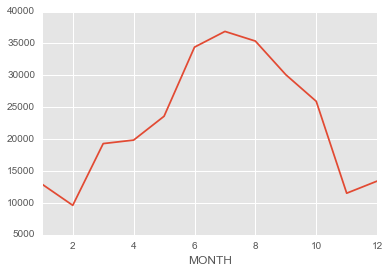

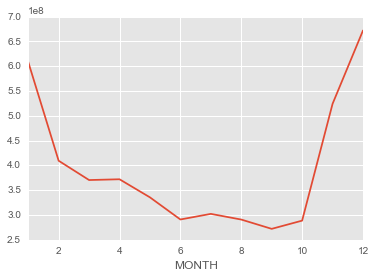

In [19]:
tar="steam"
dd="hdh"
(data["2015"].groupby("MONTH").sum()[dd]).plot()
plt.show()
((data["2015"].groupby("MONTH").sum()[tar])).plot()
#plt.scatter(a,b)

## Testing new stuff from here on

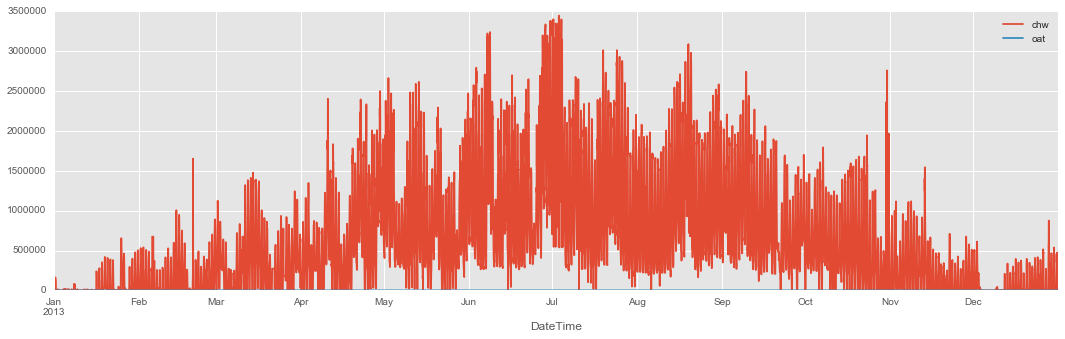

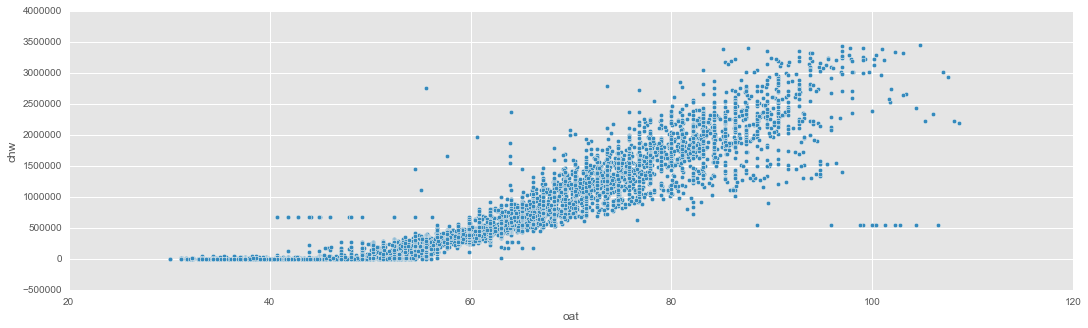

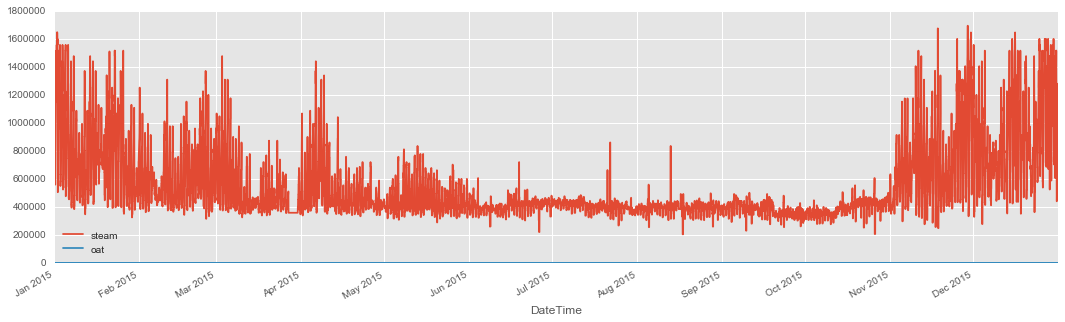

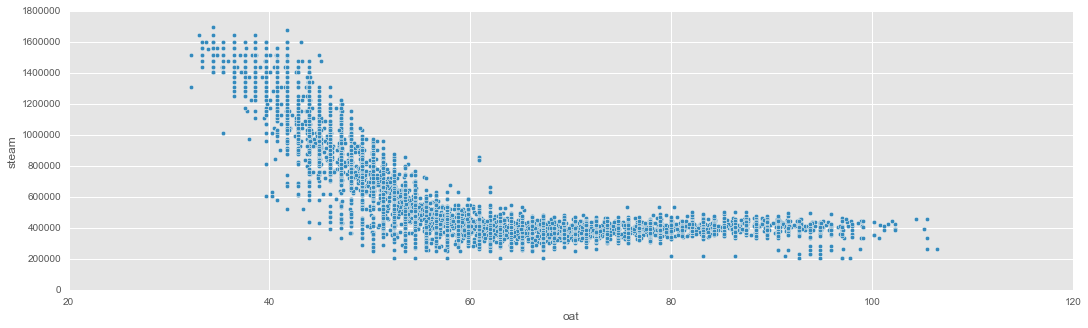

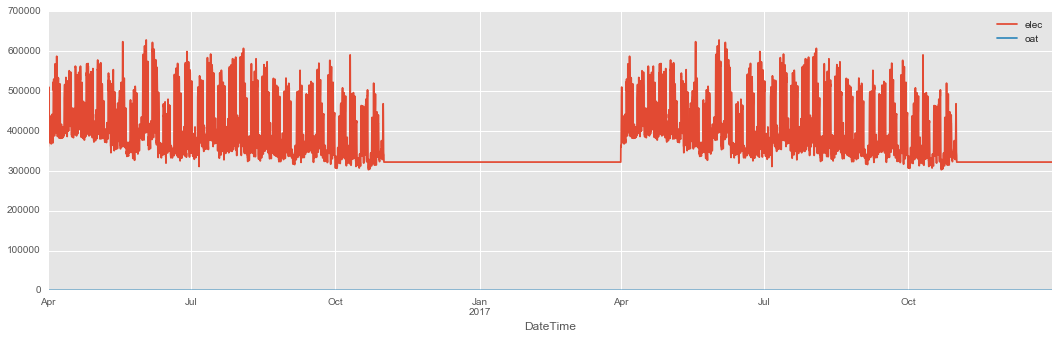

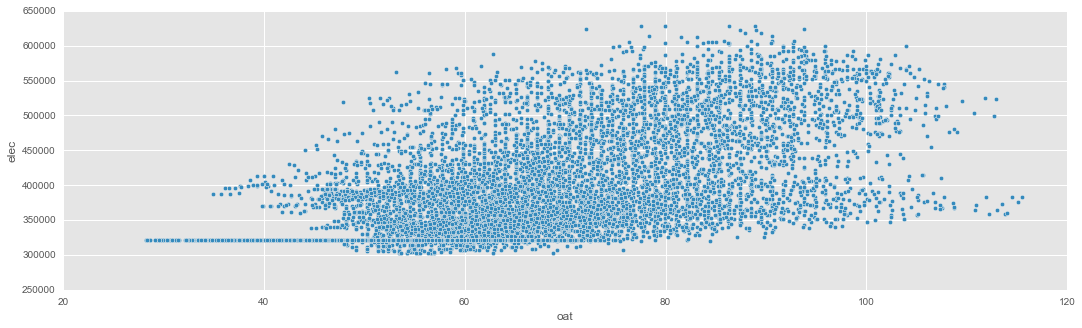

In [20]:
## MANUAL DATA CLEANING
# run existing code with n=4
## chw:  remove hours with 0 use and oat > 65F
## steam: remove hours with 0 use and oat < 65F
## elec: nothing 


#a=pd.read_csv('data/Ghausi_M&V Data.csv', index_col=0)
#a[["chw.bph","oat"]].plot(figsize=(18,5))
#a[["chw.bph","oat"]].plot(kind="scatter",x="oat",y="chw.bph", figsize=(18,5))

#data.loc["2013",["chw","oat"]].plot(figsize=(18,5))
#data.loc["2013",["chw","oat"]].plot(kind="scatter",x="oat",y="chw", figsize=(18,5))

cond=~((data["oat"]>65)&(data["chw"]==0))
data_clean=data.loc[cond,:]
data_clean.loc["2013",["chw","oat"]].plot(figsize=(18,5))
data_clean.loc["2013",["chw","oat"]].plot(kind="scatter",x="oat",y="chw", figsize=(18,5))
data_clean.loc[:,["chw","oat"]].to_csv("data/clean/Ghausi_M&V_Data_chw_clean.csv")

cond=~((data["oat"]<65)&(data["steam"]==0))
data_clean=data.loc[cond,:]
data_clean.loc["2015",["steam","oat"]].plot(figsize=(18,5))
data_clean.loc["2015",["steam","oat"]].plot(kind="scatter",x="oat",y="steam", figsize=(18,5))
data_clean.loc[:,["steam","oat"]].to_csv("data/clean/Ghausi_M&V_Data_steam_clean.csv")

cond=((data["elec"]>200000))
data_clean=data.loc[cond,:]
data_clean.loc["04-01-2016":,["elec","oat"]].plot(figsize=(18,5))
data_clean.loc["04-01-2016":,["elec","oat"]].plot(kind="scatter",x="oat",y="elec", figsize=(18,5))
data_clean.loc[:,["elec","oat"]].to_csv("data/clean/Ghausi_M&V_Data_elec_clean.csv")


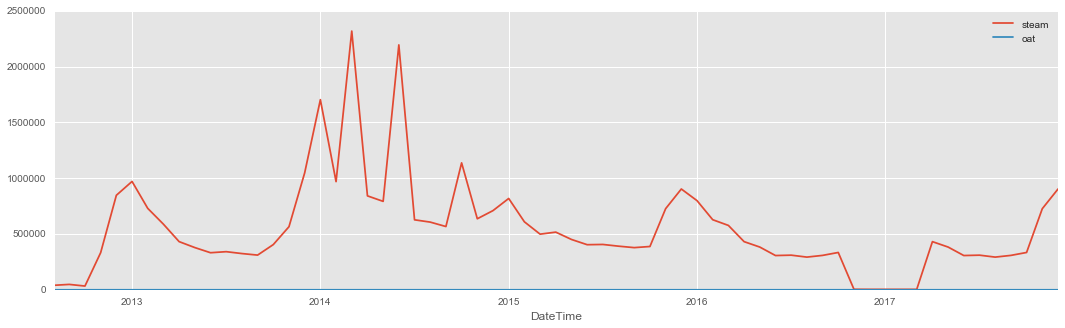

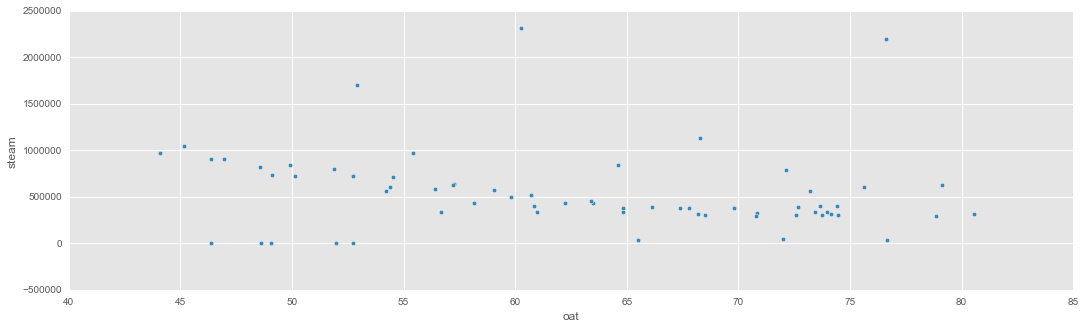

In [21]:
cond=~((data["oat"]<65)&(data["steam"]==0))
data_clean=data.loc[cond,:]
data_clean.loc[:,["steam","oat"]].groupby(pd.TimeGrouper(freq='M')).mean().plot(figsize=(18,5))
data_clean.loc[:,["steam","oat"]].groupby(pd.TimeGrouper(freq='M')).mean().plot(kind="scatter",x="oat",y="steam", figsize=(18,5))
data_clean.loc[:,["steam","oat"]].to_csv("data/clean/Ghausi_M&V_Data_steam_clean.csv")

